## Import Dataset

In [1]:
import pandas as pd

df = pd.read_csv('data/2020-01-09_21:01.csv')

df.head(df.shape[0])

,summary,cloudCover,temperatureHigh,temperatureLow,humidity,precipProbability,precipType,dewPoint,pressure,windSpeed,windGust,visibility,uvIndex,ozone
0,Overcast throughout the day.,0.84,22.03,14.69,0.76,0.40,rain,13.79,1015.7,1.59,4.24,16.093,4,235.4
1,Clear throughout the day.,0.05,25.50,11.59,0.71,0.06,rain,13.32,1016.0,3.11,7.03,16.093,6,239.8
2,Clear throughout the day.,0.00,24.42,11.30,0.65,0.03,rain,9.63,1016.7,3.19,6.58,16.093,7,241.9
3,Clear throughout the day.,0.00,25.60,12.26,0.64,0.02,rain,9.86,1014.6,3.25,6.71,16.093,7,245.4
4,Clear throughout the day.,0.00,27.02,13.26,0.54,0.01,rain,7.24,1012.1,2.47,5.43,16.093,7,249.9
5,Clear throughout the day.,0.00,28.67,14.33,0.56,0.01,rain,9.63,1012.9,1.50,3.00,16.093,7,250.7
6,Clear throughout the day.,0.00,29.32,15.46,0.56,0.01,rain,10.63,1014.3,1.50,4.20,16.093,7,251.4
7,Clear throughout the day.,0.00,28.31,16.28,0.57,0.03,rain,11.76,1015.3,1.99,5.92,16.093,7,246.8


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 14 columns):
summary              8 non-null object
cloudCover           8 non-null float64
temperatureHigh      8 non-null float64
temperatureLow       8 non-null float64
humidity             8 non-null float64
precipProbability    8 non-null float64
precipType           8 non-null object
dewPoint             8 non-null float64
pressure             8 non-null float64
windSpeed            8 non-null float64
windGust             8 non-null float64
visibility           8 non-null float64
uvIndex              8 non-null int64
ozone                8 non-null float64
dtypes: float64(11), int64(1), object(2)
memory usage: 1.0+ KB


In [3]:
features = df.columns

## Feature Engineering

### Create a Smaller dataset with one feature

In [4]:
tmp = df[['humidity']].head(8)
tmp

,humidity
0,0.76
1,0.71
2,0.65
3,0.64
4,0.54
5,0.56
6,0.56
7,0.57


### Develop an algorithm to find out the N previous days measurement of a feature 

In [5]:
# 1 day prior
N = 1
feature = 'humidity'
rows = tmp.shape[0]

# list representing Nth prior measurement
# padded with N None values to maintain the constistent rows length
nth_prior_measurements = [None]*N + [tmp[feature][i-N] for i in range(N,rows)]

# new column added to the dataframe with nth prior measurements
column_name = '{}_-{}'.format(feature, N)
tmp[column_name] = nth_prior_measurements
tmp

,humidity,humidity_-1
0,0.76,NaN
1,0.71,0.76
2,0.65,0.71
3,0.64,0.65
4,0.54,0.64
5,0.56,0.54
6,0.56,0.56
7,0.57,0.56


### Use the algorithm to find out the 3 previous days measurement of each feature

In [6]:
def get_nth_day_measurement(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    column_name = '{}_-{}'.format(feature, N)
    df[column_name] = nth_prior_measurements
    
for feature in df.columns:
    if feature != 'date' and feature != 'summary':
        for N in range(1, 4):
            get_nth_day_measurement(df, feature, N)

print('Features obtained:\n')
for f in df.columns:
    print(f)

Features obtained:

summary
cloudCover
temperatureHigh
temperatureLow
humidity
precipProbability
precipType
dewPoint
pressure
windSpeed
windGust
visibility
uvIndex
ozone
cloudCover_-1
cloudCover_-2
cloudCover_-3
temperatureHigh_-1
temperatureHigh_-2
temperatureHigh_-3
temperatureLow_-1
temperatureLow_-2
temperatureLow_-3
humidity_-1
humidity_-2
humidity_-3
precipProbability_-1
precipProbability_-2
precipProbability_-3
precipType_-1
precipType_-2
precipType_-3
dewPoint_-1
dewPoint_-2
dewPoint_-3
pressure_-1
pressure_-2
pressure_-3
windSpeed_-1
windSpeed_-2
windSpeed_-3
windGust_-1
windGust_-2
windGust_-3
visibility_-1
visibility_-2
visibility_-3
uvIndex_-1
uvIndex_-2
uvIndex_-3
ozone_-1
ozone_-2
ozone_-3


## Data Preprocessing

### Remove unnecessary columns from dataset

In [7]:
to_remove = ['summary', 'visibility',
            'precipType','precipType_-1','precipType_-2','precipType_-3']

data = df.drop(to_remove, axis=1)

### Check features' statistics to find outliers

In [8]:
statistics = df.describe().T
statistics.columns

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

In [9]:
IQR = statistics['75%'] - statistics['25%']

statistics['outliers'] = (
    (statistics['min'] < (statistics['25%'] - (3*IQR))) | 
    (statistics['max'] > (statistics['75%'] + (3*IQR)))
)

ol = statistics.loc[statistics.outliers,]

print(ol.shape[0], 'features have outliers')
ol.head(ol.shape[0])

10 features have outliers


,count,mean,std,min,25%,50%,75%,max,outliers
cloudCover,8.0,0.111250,0.294979,0.00,0.0000,0.000,0.0125,0.84,True
precipProbability,8.0,0.071250,0.133891,0.01,0.0100,0.025,0.0375,0.40,True
uvIndex,8.0,6.500000,1.069045,4.00,6.7500,7.000,7.0000,7.00,True
cloudCover_-1,7.0,0.127143,0.314892,0.00,0.0000,0.000,0.0250,0.84,True
cloudCover_-2,6.0,0.148333,0.339436,0.00,0.0000,0.000,0.0375,0.84,True
cloudCover_-3,5.0,0.178000,0.370702,0.00,0.0000,0.000,0.0500,0.84,True
precipProbability_-1,7.0,0.077143,0.143494,0.01,0.0100,0.020,0.0450,0.40,True
precipProbability_-2,6.0,0.088333,0.153807,0.01,0.0125,0.025,0.0525,0.40,True
precipProbability_-3,5.0,0.104000,0.166523,0.01,0.0200,0.030,0.0600,0.40,True
uvIndex_-1,7.0,6.428571,1.133893,4.00,6.5000,7.000,7.0000,7.00,True


### Analyze the outliers

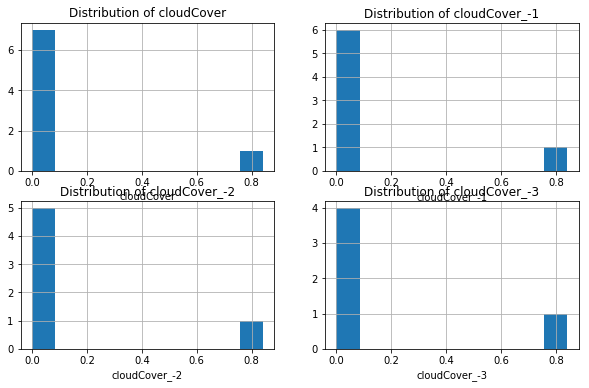

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
data['cloudCover'].hist()
plt.title('Distribution of cloudCover')
plt.xlabel('cloudCover')

plt.subplot(2,2,2)
data['cloudCover_-1'].hist()
plt.title('Distribution of cloudCover_-1')
plt.xlabel('cloudCover_-1')

plt.subplot(2,2,3)
data['cloudCover_-2'].hist()
plt.title('Distribution of cloudCover_-2')
plt.xlabel('cloudCover_-2')

plt.subplot(2,2,4)
data['cloudCover_-3'].hist()
plt.title('Distribution of cloudCover_-3')
plt.xlabel('cloudCover_-3')

plt.show()

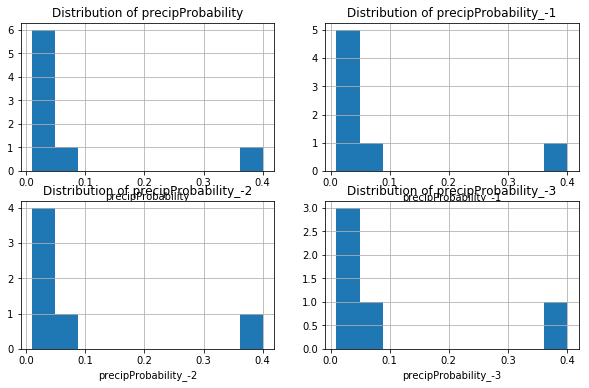

In [11]:
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
data['precipProbability'].hist()
plt.title('Distribution of precipProbability')
plt.xlabel('precipProbability')

plt.subplot(2,2,2)
data['precipProbability_-1'].hist()
plt.title('Distribution of precipProbability_-1')
plt.xlabel('precipProbability_-1')

plt.subplot(2,2,3)
data['precipProbability_-2'].hist()
plt.title('Distribution of precipProbability_-2')
plt.xlabel('precipProbability_-2')

plt.subplot(2,2,4)
data['precipProbability_-3'].hist()
plt.title('Distribution of precipProbability_-3')
plt.xlabel('precipProbability_-3')

plt.show()

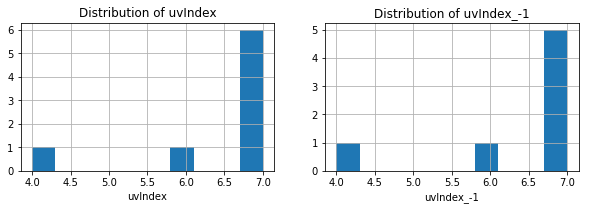

In [12]:
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
data['uvIndex'].hist()
plt.title('Distribution of uvIndex')
plt.xlabel('uvIndex')

plt.subplot(2,2,2)
data['uvIndex_-1'].hist()
plt.title('Distribution of uvIndex_-1')
plt.xlabel('uvIndex_-1')

plt.show()

### Check for missing data

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 47 columns):
cloudCover              8 non-null float64
temperatureHigh         8 non-null float64
temperatureLow          8 non-null float64
humidity                8 non-null float64
precipProbability       8 non-null float64
dewPoint                8 non-null float64
pressure                8 non-null float64
windSpeed               8 non-null float64
windGust                8 non-null float64
uvIndex                 8 non-null int64
ozone                   8 non-null float64
cloudCover_-1           7 non-null float64
cloudCover_-2           6 non-null float64
cloudCover_-3           5 non-null float64
temperatureHigh_-1      7 non-null float64
temperatureHigh_-2      6 non-null float64
temperatureHigh_-3      5 non-null float64
temperatureLow_-1       7 non-null float64
temperatureLow_-2       6 non-null float64
temperatureLow_-3       5 non-null float64
humidity_-1             7 non-null float6

In [14]:
data.head(data.shape[0])

,cloudCover,temperatureHigh,temperatureLow,humidity,precipProbability,dewPoint,pressure,windSpeed,windGust,uvIndex,...,windGust_-3,visibility_-1,visibility_-2,visibility_-3,uvIndex_-1,uvIndex_-2,uvIndex_-3,ozone_-1,ozone_-2,ozone_-3
0,0.84,22.03,14.69,0.76,0.40,13.79,1015.7,1.59,4.24,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.05,25.50,11.59,0.71,0.06,13.32,1016.0,3.11,7.03,6,...,NaN,16.093,NaN,NaN,4.0,NaN,NaN,235.4,NaN,NaN
2,0.00,24.42,11.30,0.65,0.03,9.63,1016.7,3.19,6.58,7,...,NaN,16.093,16.093,NaN,6.0,4.0,NaN,239.8,235.4,NaN
3,0.00,25.60,12.26,0.64,0.02,9.86,1014.6,3.25,6.71,7,...,4.24,16.093,16.093,16.093,7.0,6.0,4.0,241.9,239.8,235.4
4,0.00,27.02,13.26,0.54,0.01,7.24,1012.1,2.47,5.43,7,...,7.03,16.093,16.093,16.093,7.0,7.0,6.0,245.4,241.9,239.8
5,0.00,28.67,14.33,0.56,0.01,9.63,1012.9,1.50,3.00,7,...,6.58,16.093,16.093,16.093,7.0,7.0,7.0,249.9,245.4,241.9
6,0.00,29.32,15.46,0.56,0.01,10.63,1014.3,1.50,4.20,7,...,6.71,16.093,16.093,16.093,7.0,7.0,7.0,250.7,249.9,245.4
7,0.00,28.31,16.28,0.57,0.03,11.76,1015.3,1.99,5.92,7,...,5.43,16.093,16.093,16.093,7.0,7.0,7.0,251.4,250.7,249.9


### Handle missing data

In [15]:
data.fillna(data.mean(), inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 47 columns):
cloudCover              8 non-null float64
temperatureHigh         8 non-null float64
temperatureLow          8 non-null float64
humidity                8 non-null float64
precipProbability       8 non-null float64
dewPoint                8 non-null float64
pressure                8 non-null float64
windSpeed               8 non-null float64
windGust                8 non-null float64
uvIndex                 8 non-null int64
ozone                   8 non-null float64
cloudCover_-1           8 non-null float64
cloudCover_-2           8 non-null float64
cloudCover_-3           8 non-null float64
temperatureHigh_-1      8 non-null float64
temperatureHigh_-2      8 non-null float64
temperatureHigh_-3      8 non-null float64
temperatureLow_-1       8 non-null float64
temperatureLow_-2       8 non-null float64
temperatureLow_-3       8 non-null float64
humidity_-1             8 non-null float6

### Create target column for the mean temperature

In [17]:
data['meanTemp'] = data.apply(lambda row: (row.temperatureHigh+row.temperatureLow)/2, axis=1)

### Save the preprocessed data

In [18]:
data.to_csv('data/data_preprocessed.csv', index=False)